<a href="https://colab.research.google.com/github/Awynimantha/Research-ML-scripts/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import gc as gc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from google.colab import drive
drive.mount('/content/drive')

# file1 = h5py.File("/content/drive/MyDrive/signal data/dataset-benign-latest.h5", "r")
# file2 = h5py.File("/content/drive/MyDrive/signal data/dataset-infected-latest.h5", "r")
# file3 = h5py.File("/content/drive/MyDrive/signal data/dataset-infected-test.h5", "r")
# file4 = h5py.File("/content/drive/MyDrive/signal data/test-data-idle.h5", "r")
file1 = h5py.File("/content/drive/MyDrive/signal data/big-benign.h5", "r")
file2 = h5py.File("/content/drive/MyDrive/signal data/big-infected.h5", "r")
file3 = h5py.File("/content/drive/MyDrive/signal data/test-benign-idle-5.h5", "r")
file4 = h5py.File("/content/drive/MyDrive/signal data/test-infected-idle-5.h5", "r")
file5 = h5py.File("/content/drive/MyDrive/signal data/test-data.h5", "r")

file6 = h5py.File("/content/drive/MyDrive/signal data/benign-vm.h5", "r")
file7 = h5py.File("/content/drive/MyDrive/signal data/infected-gamesall.h5", "r")

Num GPUs Available: 0


MessageError: Error: credential propagation was unsuccessful

In [ ]:
print(file1.keys())
print(file2.keys())

<KeysViewHDF5 ['benign-idle0', 'benign-idle0_file3', 'benign-idle0_file3_file4', 'benign-idle0_file4', 'benign-idle0_file5', 'benign-idle0_file8', 'benign-idle1', 'benign-idle10', 'benign-idle10_file3', 'benign-idle10_file3_file4', 'benign-idle10_file4', 'benign-idle10_file5', 'benign-idle10_file8', 'benign-idle11', 'benign-idle11_file3', 'benign-idle11_file4', 'benign-idle11_file8', 'benign-idle12', 'benign-idle12_file3', 'benign-idle12_file3_file4', 'benign-idle12_file4', 'benign-idle12_file5', 'benign-idle12_file8', 'benign-idle13', 'benign-idle13_file3', 'benign-idle13_file3_file4', 'benign-idle13_file4', 'benign-idle13_file5', 'benign-idle13_file8', 'benign-idle14', 'benign-idle14_file3', 'benign-idle14_file3_file4', 'benign-idle14_file4', 'benign-idle14_file5', 'benign-idle14_file8', 'benign-idle15', 'benign-idle15_file3', 'benign-idle15_file3_file4', 'benign-idle15_file4', 'benign-idle15_file8', 'benign-idle16', 'benign-idle16_file3', 'benign-idle16_file3_file4', 'benign-idle16_

In [ ]:
import h5py
import tensorflow as tf
import numpy as np

file1 = h5py.File("/content/drive/MyDrive/signal data/big-benign.h5", "r")
file2 = h5py.File("/content/drive/MyDrive/signal data/big-infected.h5", "r")

def compute_nicv_fixed(num_samples=10):
    """Compute NICV scores for each frequency bin across multiple samples per class."""

    benign_keys = list(file1.keys())
    infected_keys = list(file2.keys())

    # Randomly choose 'num_samples' from each class
    benign_keys = np.random.choice(benign_keys, size=num_samples, replace=False)
    infected_keys = np.random.choice(infected_keys, size=num_samples, replace=False)

    benign_magnitudes = []
    infected_magnitudes = []

    # First: figure out the minimum signal length across all selected samples
    lengths = []
    for key in benign_keys:
        lengths.append(len(file1[key]))
    for key in infected_keys:
        lengths.append(len(file2[key]))
    min_len = min(lengths)

    def compute_stft_magnitude(dataset):
        # Truncate to min_len
        signal = dataset[:min_len]
        tensor = tf.convert_to_tensor(signal, dtype=tf.float32)
        Zxx = tf.signal.stft(tensor, frame_length=4096, frame_step=2048, fft_length=4096)
        return tf.abs(Zxx).numpy()

    # Compute STFT magnitudes
    for key in benign_keys:
        benign_magnitudes.append(compute_stft_magnitude(file1[key]))

    for key in infected_keys:
        infected_magnitudes.append(compute_stft_magnitude(file2[key]))

    benign_magnitudes = np.stack(benign_magnitudes)  # shape: [N, T, F]
    infected_magnitudes = np.stack(infected_magnitudes)  # shape: [N, T, F]

    # Combine and reshape
    all_magnitudes = np.concatenate([benign_magnitudes, infected_magnitudes], axis=0)  # [2N, T, F]

    # NICV is calculated per frequency bin (averaged over time and samples)
    benign_mean_time = benign_magnitudes.mean(axis=1)  # shape: [N, F]
    infected_mean_time = infected_magnitudes.mean(axis=1)  # shape: [N, F]
    combined_mean_time = all_magnitudes.mean(axis=1)  # shape: [2N, F]

    total_variance = np.var(combined_mean_time, axis=0)  # [F]

    benign_class_mean = benign_mean_time.mean(axis=0)  # [F]
    infected_class_mean = infected_mean_time.mean(axis=0)  # [F]
    overall_mean = combined_mean_time.mean(axis=0)  # [F]

    n = benign_mean_time.shape[0]
    between_class_variance = (
        n * (benign_class_mean - overall_mean) ** 2 +
        n * (infected_class_mean - overall_mean) ** 2
    )  # [F]

    nicv_values = between_class_variance / (total_variance + 1e-8)  # [F]

    return nicv_values


In [ ]:
nicv_scores = compute_nicv_fixed()
np.save("/content/drive/MyDrive/nicv/(4096,2048)", nicv_scores)


In [ ]:
nicv_values = np.load("/content/drive/MyDrive/nicv/(4096,2048).npy")

In [ ]:
nicv_scores = nicv_values
n_components = 100

keys =  list(file1.keys())[:100] + list(file2.keys())[0:100] + list(file1.keys())[100:] + list(file2.keys())[100:]
X_batch = []
y_batch = []
for name in keys:
  data = []
  label = 0
  if name in file1:
    label = 0
    data = file1[name]
  else:
    label = 1
    data = file2[name]
  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_batch.append(final_features)
  y_batch.append(label)


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [ ]:
import numpy as np

X_batch_np = np.array(X_batch)
y_batch_np = np.array(y_batch)

# Save to .npy files
np.save('/content/drive/MyDrive/mlp/X_batch.npy', X_batch_np)
np.save('/content/drive/MyDrive/mlp/y_batch.npy', y_batch_np)


In [ ]:
import numpy as np

X_batch_loaded = np.load('/content/drive/MyDrive/mlp/X_batch.npy')
y_batch_loaded = np.load('/content/drive/MyDrive/mlp/y_batch.npy')

# Optional: print shapes to verify
print(X_batch_loaded.shape)
print(y_batch_loaded.shape)


(509, 100)
(509,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X_batch_loaded, y_batch_loaded, test_size=0.3, random_state=42)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X_batch_loaded, y_batch_loaded, test_size=0.3, random_state=42)
model = Sequential([
    Dense(32, activation='relu', input_shape=(100,)),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(np.array(X_train_global), np.array(y_train_global), epochs=350, batch_size=10, validation_data=(np.array(X_test_global), np.array(y_test_global)), verbose=1)

Epoch 1/350


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5082 - loss: 2.7383 - val_accuracy: 0.5163 - val_loss: 0.8406
Epoch 2/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5367 - loss: 1.4930 - val_accuracy: 0.8889 - val_loss: 0.6283
Epoch 3/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5356 - loss: 0.9671 - val_accuracy: 0.4837 - val_loss: 0.6965
Epoch 4/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.8323 - val_accuracy: 0.4837 - val_loss: 0.7004
Epoch 5/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5265 - loss: 0.7816 - val_accuracy: 0.4837 - val_loss: 0.6976
Epoch 6/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5467 - loss: 0.7571 - val_accuracy: 0.4837 - val_loss: 0.6976
Epoch 7/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5820 - loss: 0.6906 - val_accuracy: 0.4837 - val_loss: 0.6972
Epoch 8/350
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 0.6991 - val_accuracy: 0.4837 - val_loss: 0.

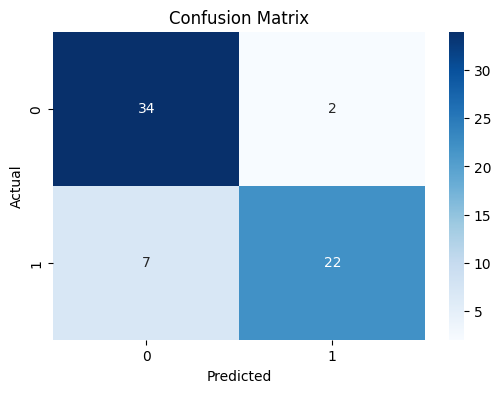

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_batch, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(np.array(X_test_batch), np.array(y_test_batch), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9000


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/mlp/model(4096,2048)-87.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/mlp/model(4096,2048)-87.h5')

# Now you can use the loaded model for prediction or further training
# For example, to make predictions:
# predictions = model.predict(new_data)


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Set number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store scores
fold_accuracies = []
model2 = None
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train_global)):
    print(f"Training Fold {fold + 1}/{k}...")

    # Split data
    X_train, X_test = X_train_global[train_idx], X_test_global[test_idx]
    y_train, y_test = y_train_global[train_idx], y_test_global[test_idx]

    # Define MLP model
    model = Sequential([
      Dense(32, activation='relu', input_shape=(500,)),
      Dropout(0.3),
      Dense(16, activation='relu'),
      Dropout(0.3),
      Dense(8, activation='relu'),
      Dropout(0.3),
      Dense(4, activation='relu'),
      Dense(1, activation='sigmoid')
    ])


    # Compile the model
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model2.fit(X_train, y_train, epochs=400, batch_size=10,
                        validation_data=(X_test, y_test), verbose=2)

    # Evaluate the model
    _, accuracy = model2.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}\n")

# Print final cross-validation accuracy
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


Training Fold 1/5...


IndexError: index 158 is out of bounds for axis 0 with size 153

In [ ]:
nicv_scores = nicv_values
n_components = 100

keys =  list(file3.keys())[:100] + list(file4.keys())[0:100] + list(file3.keys())[100:] + list(file4.keys())[100:]
X_test_batch = []
y_test_batch = []
for name in keys:
  data = []
  label = 0
  if name in file3:
    label = 0
    data = file3[name]
  else:
    label = 1
    data = file4[name]
  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch.append(final_features)
  y_test_batch.append(label)




In [ ]:
nicv_scores = nicv_values
n_components = 100

keys =  list(file5.keys())
for name in keys:
  data = []
  label = 0
  if(file5[name].attrs.get('label') == "benign"):
    label = 0
    data = file5[name]
  else:
    label = 1
    data = file5[name]
  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch.append(final_features)
  y_test_batch.append(label)


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(np.array(X_test_global), np.array(y_test_global), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9020


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_global))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_global, y_pred))


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        79
           1       0.83      1.00      0.91        74

    accuracy                           0.90       153
   macro avg       0.92      0.91      0.90       153
weighted avg       0.92      0.90      0.90       153



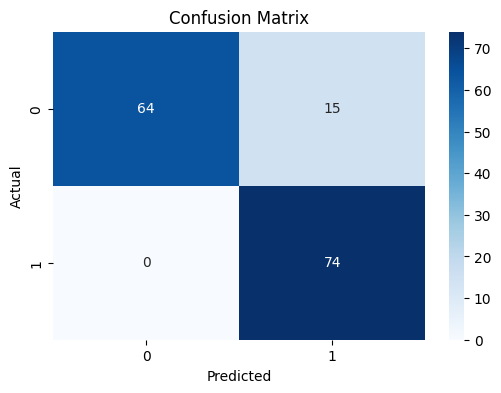

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_global, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(np.array(X_test_batch), np.array(y_test_batch), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8769


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(np.array(X_test_batch), np.array(y_test_batch), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8769


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        36
           1       0.78      1.00      0.88        29

    accuracy                           0.88        65
   macro avg       0.89      0.89      0.88        65
weighted avg       0.90      0.88      0.88        65



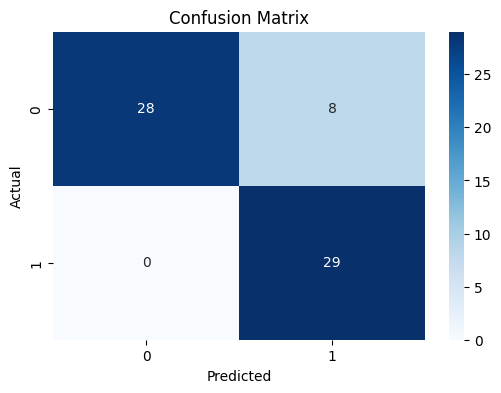

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_batch, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


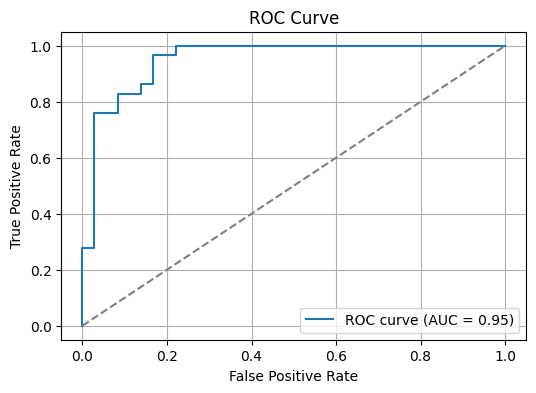

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_probs = model.predict(np.array(X_test_batch))

# Get FPR, TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test_batch, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# test

In [ ]:
file6 = h5py.File("/content/drive/MyDrive/signal data/benign-single.h5", "r")
file7 = h5py.File("/content/drive/MyDrive/signal data/infected-single.h5", "r")
file8 = h5py.File("/content/drive/MyDrive/signal data/benign-gamesall.h5", "r")
file9 = h5py.File("/content/drive/MyDrive/signal data/infected-gamesall.h5", "r")

In [ ]:
import numpy as np

file_path = "/content/drive/MyDrive/nicv/(4096,2048).npy"
nicv_values = np.load(file_path)

nicv_scores = nicv_values
n_components = 100
file = file8
keys =  list(file.keys())
X_test_batch_gamesall = []
y_test_batch_gamesall = []
for name in keys:
  data = []
  label = 1
  data = file[name]

  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch_gamesall.append(final_features)
  y_test_batch_gamesall.append(label)




/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [ ]:
X_test_batch = np.load("/content/drive/MyDrive/stft_data/X_batch(4096,2048)_test_noise.npy", "r")
y_test_batch = np.load("/content/drive/MyDrive/stft_data/y_batch(4096,2048)_test_noise.npy", "r")

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(np.array(X_test_batch), np.array(y_test_batch), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8800


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        53
           1       0.80      1.00      0.89        47

    accuracy                           0.88       100
   macro avg       0.90      0.89      0.88       100
weighted avg       0.90      0.88      0.88       100



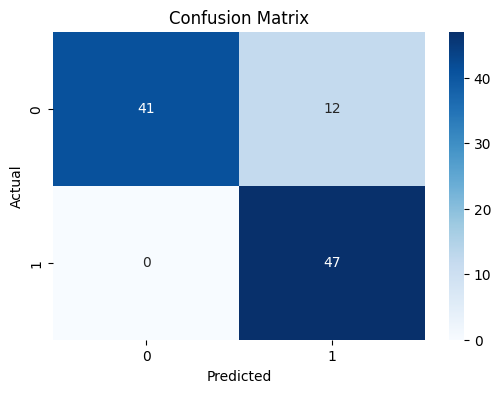

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_batch, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


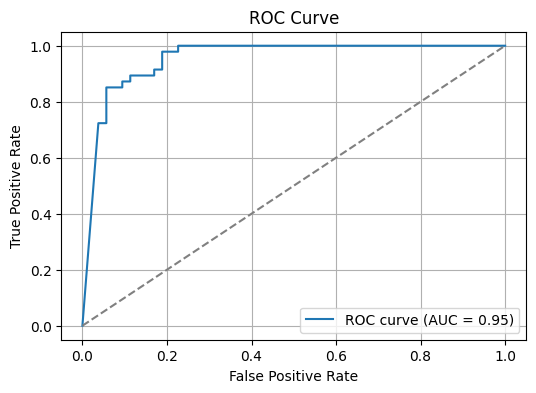

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_probs = model.predict(np.array(X_test_batch))

# Get FPR, TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test_batch, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
file6 = h5py.File("/content/drive/MyDrive/signal data/benign-single.h5", "r")
file7 = h5py.File("/content/drive/MyDrive/signal data/infected-single.h5", "r")
file8 = h5py.File("/content/drive/MyDrive/signal data/benign-gamesall.h5", "r")
file9 = h5py.File("/content/drive/MyDrive/signal data/infected-gamesall.h5", "r")

# infected gamesall


In [ ]:
import numpy as np

file_path = "/content/drive/MyDrive/nicv/(4096,2048).npy"
nicv_values = np.load(file_path)

nicv_scores = nicv_values
n_components = 100
file = file6
keys =  list(file.keys())
X_test_batch_vm = []
y_test_batch_vm = []
for name in keys:
  data = []
  label = 0
  data = file[name]

  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch_vm.append(final_features)
  y_test_batch_vm.append(label)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       0.00      0.00      0.00         0

    accuracy                           0.40         5
   macro avg       0.50      0.20      0.29         5
weighted avg       1.00      0.40      0.57         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


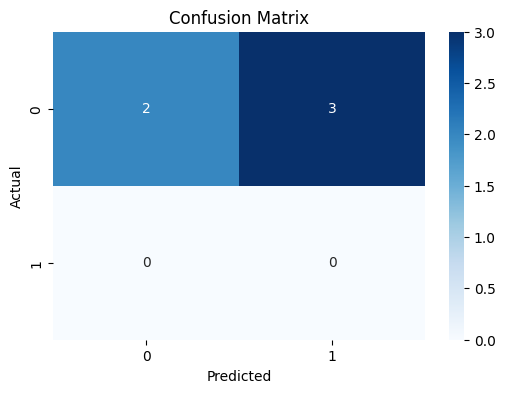

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch_vm))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch_vm, y_pred))
cm = confusion_matrix(y_test_batch_vm, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

file_path = "/content/drive/MyDrive/nicv/(4096,2048).npy"
nicv_values = np.load(file_path)

nicv_scores = nicv_values
n_components = 100
file = file7
keys =  list(file.keys())
X_test_batch_gamesall = []
y_test_batch_gamesall = []
for name in keys:
  data = []
  label = 1
  data = file[name]

  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch_gamesall.append(final_features)
  y_test_batch_gamesall.append(label)




/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



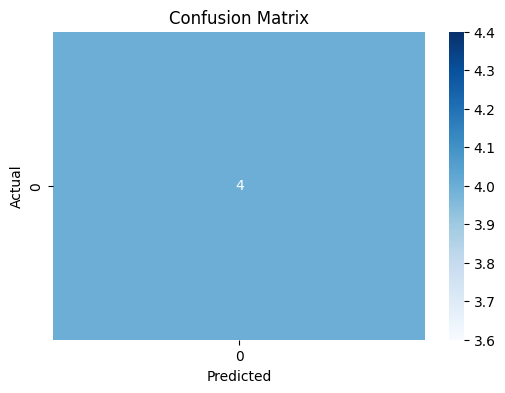

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch_gamesall))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch_gamesall, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
cm = confusion_matrix(y_test_batch_gamesall, y_pred)


In [ ]:
import numpy as np

file_path = "/content/drive/MyDrive/nicv/(4096,2048).npy"
nicv_values = np.load(file_path)

nicv_scores = nicv_values
n_components = 100
file = file8
keys =  list(file.keys())
X_test_batch_gamesall = []
y_test_batch_gamesall = []
for name in keys:
  data = []
  label = 0
  data = file[name]

  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch_gamesall.append(final_features)
  y_test_batch_gamesall.append(label)




/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       3.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

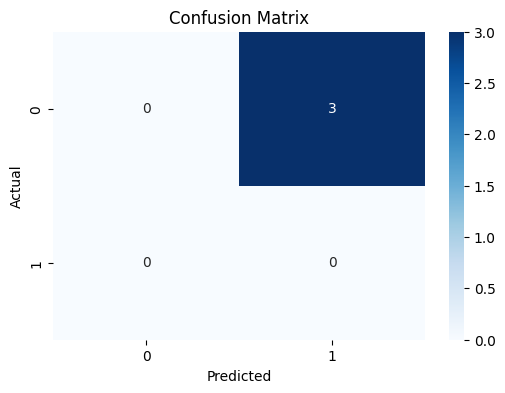

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch_gamesall))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch_gamesall, y_pred))

cm = confusion_matrix(y_test_batch_gamesall, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

file_path = "/content/drive/MyDrive/nicv/(4096,2048).npy"
nicv_values = np.load(file_path)

nicv_scores = nicv_values
n_components = 100
file = file9
keys =  list(file.keys())
X_test_batch_gamesall = []
y_test_batch_gamesall = []
for name in keys:
  data = []
  label = 1
  data = file[name]

  data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
  Zxx = tf.signal.stft(data_tensor, frame_length=4096, frame_step=2048, fft_length=4096)
  magnitude = tf.abs(Zxx).numpy().reshape(Zxx.shape[0], -1)
  selected_indices = np.argsort(nicv_scores)[-n_components:]
  reduced_features = magnitude[:, selected_indices]
  final_features = np.mean(reduced_features, axis=0)
  X_test_batch_gamesall.append(final_features)
  y_test_batch_gamesall.append(label)




/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [ ]:
print(y_test_batch_gamesall)

[1, 1, 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


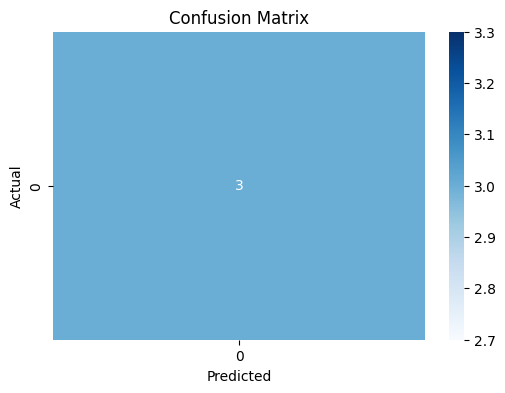

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test_batch_gamesall))
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test_batch_gamesall, y_pred))

cm = confusion_matrix(y_test_batch_gamesall, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
